In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from glob import glob
import pandas as pd
from tqdm.autonotebook import tqdm
import seaborn as sns
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import lmfit
from avgn.model_fitting import *
import avgn.spectrogramming.spectrogramming as sg
from avgn.network_analysis.network_analysis import *

### Load sequence df

In [4]:
#Its recommended to modify the sequence_dfs variable with an absolute path.
sequence_dfs = glob('../../../data/sequence_df/BF/Bird*/*/*.pickle')

In [5]:
from datetime import datetime

In [6]:
sdf_table = pd.DataFrame([[sdf.split('/')[-3], datetime.strptime(sdf.split('/')[-2],"%Y-%m-%d_%H-%M-%S"), sdf] for sdf in sequence_dfs], columns=['bird', 'dt', 'sdf']).sort_values(by='dt')

In [7]:
sdf_table[:3]

bird                  dt  \
1  Bird0_umap 2018-10-22 16:40:19   
3  Bird4_umap 2018-10-22 16:40:19   
5  Bird9_umap 2018-10-22 16:40:19   

                                                 sdf  
1  ../../../data/sequence_df/BF/Bird0_umap/2018-1...  
3  ../../../data/sequence_df/BF/Bird4_umap/2018-1...  
5  ../../../data/sequence_df/BF/Bird9_umap/2018-1...

In [8]:
seq_dfs = []

for bird in np.unique(sdf_table.bird):    
    sdf_early = np.argsort(sdf_table[sdf_table.bird ==bird].dt).values[-1]
    sdf = sdf_table[sdf_table.bird ==bird].sdf.values[sdf_early]
    seq_df = pd.read_pickle(sdf)
    seq_df['bird_name'] = bird.split('_')[-2]
    print(bird.split('_')[-2])    
    seq_dfs.append(seq_df)
seq_dfs = pd.concat(seq_dfs)

Bird0
Bird2
Bird4
Bird5
Bird6
Bird7
Bird9


In [9]:
seq_dfs[:3]

sequence_num                                      sequence_type  \
0           0.0  [labels, z, original_wav, specs, start_time_re...   
1           1.0  [labels, z, original_wav, specs, start_time_re...   
2           2.0  [labels, z, original_wav, specs, start_time_re...   

                                            sequence  \
0  [2, 13, 11, 7, 9, 3, 4, 4, 4, 2, 1, 10, 12, 8,...   
1  [6, 6, 12, 11, 13, 13, 12, 11, 7, 9, 3, 4, 4, ...   
2  [6, 6, 13, 11, 13, 11, 13, 11, 13, 5, 5, 5, 10...   

                                                   z  \
0  [[-2.198026959683159, 17.607802827808186], [8....   
1  [[-4.2959097073300025, -7.123384665931179], [-...   
2  [[-4.309374022326335, -7.029500196076765], [-4...   

                                        original_wav  \
0  [[../../../data/bf_wav/Bird0/wavs/1900-03-03_0...   
1  [[../../../data/bf_wav/Bird0/wavs/1900-03-03_0...   
2  [[../../../data/bf_wav/Bird0/wavs/1900-03-03_0...   

                                               specs  \
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   

                                  start_time_rel_wav  \
0  [1143.984619140625, 37113.5, 42305.4296875, 47...   
1  [19249.76171875, 37157.5390625, 41953.48046875...   
2  [23077.595703125, 37135.34765625, 42349.257812...   

                                       syll_length_s  lens bird_name  
0  [0.15881036221981049, 0.058436714112758636, 0....    69     Bird0  
1  [0.041936978697776794, 0.04949938505887985, 0....    72     Bird0  
2  [0.042624250054359436, 0.045374203473329544, 0...    73     Bird0

### look at individual sequences

In [10]:
def colormap_seqs(seqs, sort_by=None, palette = "Set1"):
    """ produces a colormap for sequences
    """
    seq_lens = [len(i) for i in seqs]
    seq_df = pd.DataFrame([list(i) for i in seqs])
    seq_df[np.isnan(seq_df)] = -2
    if sort_by !=None:
        seq_df = seq_df.sort_values(by=sort_by)
    seqs = seq_df.values
    unique_labs= np.unique(np.concatenate(seqs))
    pal = [[1,1,1]] + [[.5,.5,.5]] + sns.color_palette(palette, len(np.unique(np.concatenate(seqs)-2)))
    cols = {lab:col for lab, col in zip(unique_labs, pal)}
    # fill canvas
    canvas = np.zeros((len(seqs), np.max(seq_lens), 3))
    for seqi, seq in (enumerate(seqs)):
        for ii,item in enumerate(seq):
            canvas[seqi,ii, :] = cols[item]
    return seq_df, canvas, cols

In [11]:
spec_params = {
    'preemphasis':0.97, 
    'frame_shift_ms':4, # step size for fft
    'frame_length_ms':12, # frame length for fft
    'min_level_db':-40, # minimum threshold db for computing spe 
    'ref_level_db':100, # reference db for computing spec
    'sample_rate':24414, # sample rate of your data
    'num_freq':512, # how many channels to use in a spectrogram 
}

In [12]:
seq_dfs[:3]

sequence_num                                      sequence_type  \
0           0.0  [labels, z, original_wav, specs, start_time_re...   
1           1.0  [labels, z, original_wav, specs, start_time_re...   
2           2.0  [labels, z, original_wav, specs, start_time_re...   

                                            sequence  \
0  [2, 13, 11, 7, 9, 3, 4, 4, 4, 2, 1, 10, 12, 8,...   
1  [6, 6, 12, 11, 13, 13, 12, 11, 7, 9, 3, 4, 4, ...   
2  [6, 6, 13, 11, 13, 11, 13, 11, 13, 5, 5, 5, 10...   

                                                   z  \
0  [[-2.198026959683159, 17.607802827808186], [8....   
1  [[-4.2959097073300025, -7.123384665931179], [-...   
2  [[-4.309374022326335, -7.029500196076765], [-4...   

                                        original_wav  \
0  [[../../../data/bf_wav/Bird0/wavs/1900-03-03_0...   
1  [[../../../data/bf_wav/Bird0/wavs/1900-03-03_0...   
2  [[../../../data/bf_wav/Bird0/wavs/1900-03-03_0...   

                                               specs  \
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   

                                  start_time_rel_wav  \
0  [1143.984619140625, 37113.5, 42305.4296875, 47...   
1  [19249.76171875, 37157.5390625, 41953.48046875...   
2  [23077.595703125, 37135.34765625, 42349.257812...   

                                       syll_length_s  lens bird_name  
0  [0.15881036221981049, 0.058436714112758636, 0....    69     Bird0  
1  [0.041936978697776794, 0.04949938505887985, 0....    72     Bird0  
2  [0.042624250054359436, 0.045374203473329544, 0...    73     Bird0

(array([ 8., 38., 14., 31., 29., 15.,  8., 13.,  5.,  2.]),
 array([ 65. ,  72.8,  80.6,  88.4,  96.2, 104. , 111.8, 119.6, 127.4,
        135.2, 143. ]),
 <a list of 10 Patch objects>)

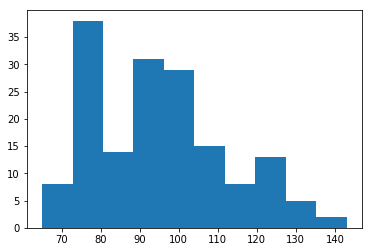

In [18]:
plt.hist([len(i) for i in subset_df.z.values])

In [50]:
cols

{-1: 'h', 0: 'l', 1: 's'}

Bird9


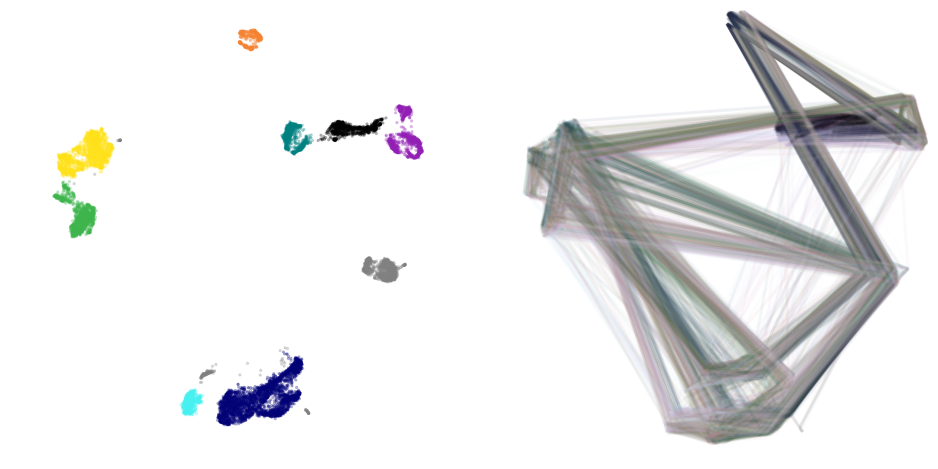

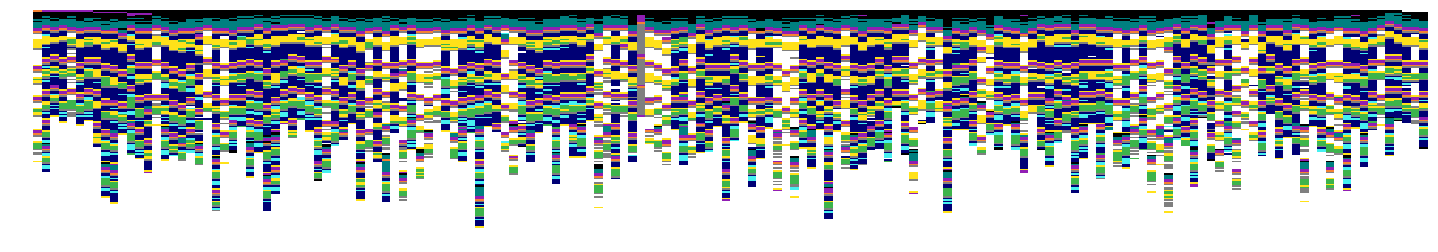

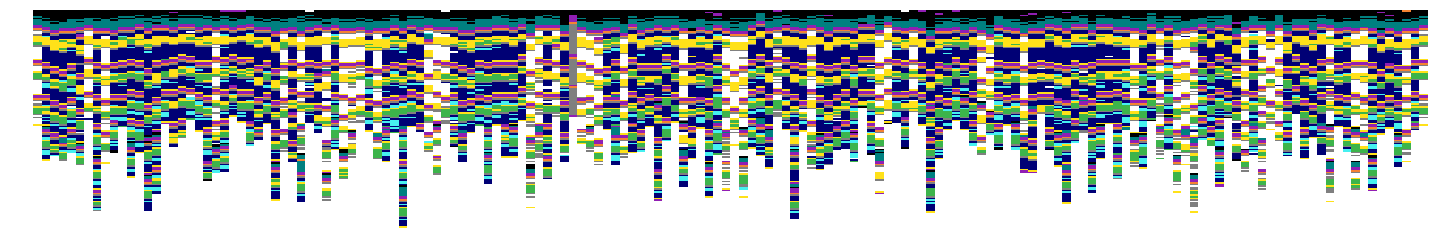

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


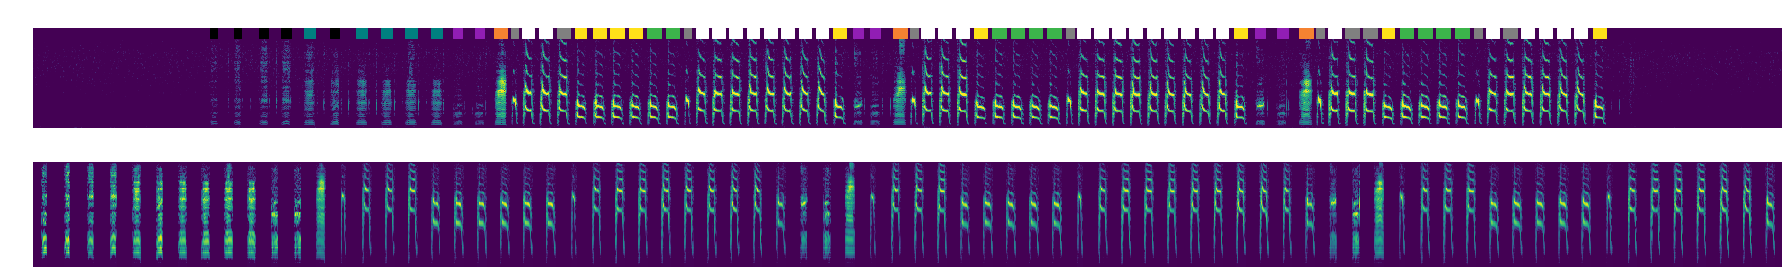

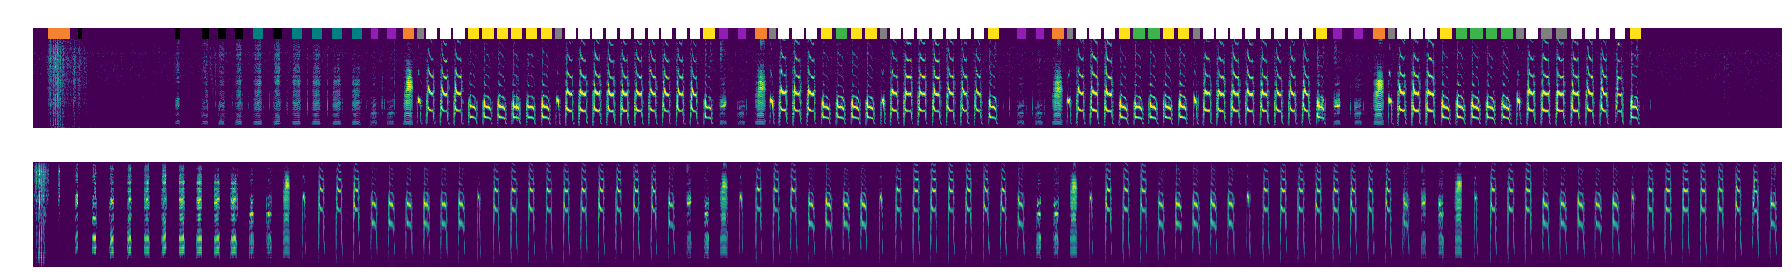

Bird7


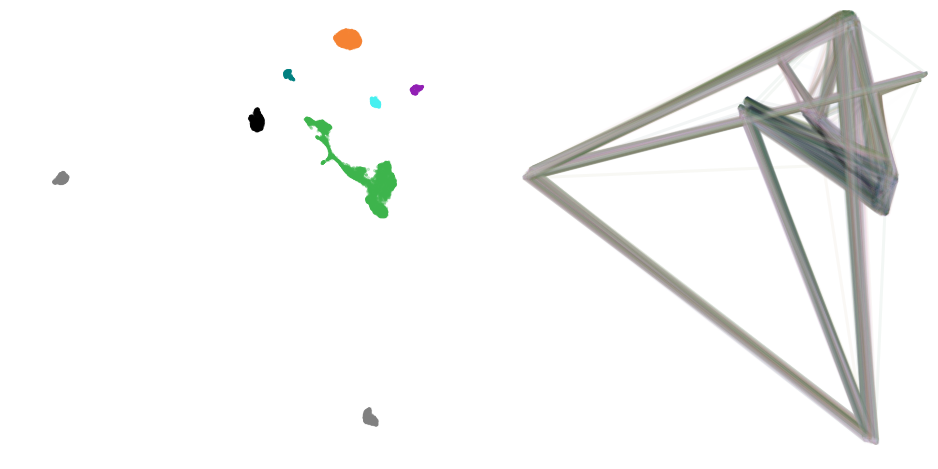

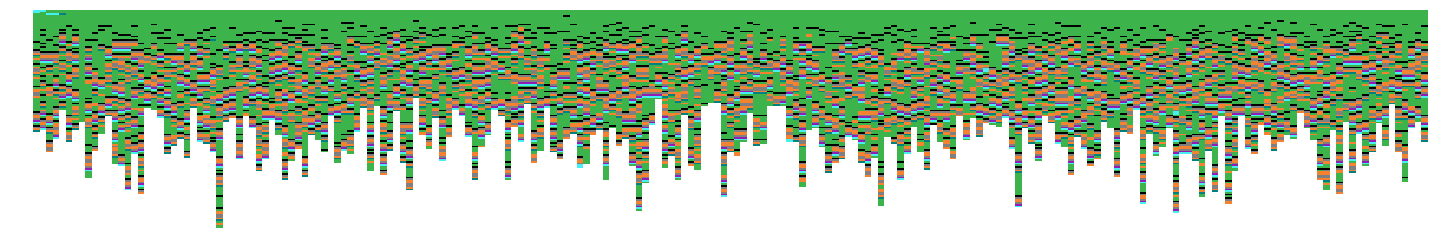

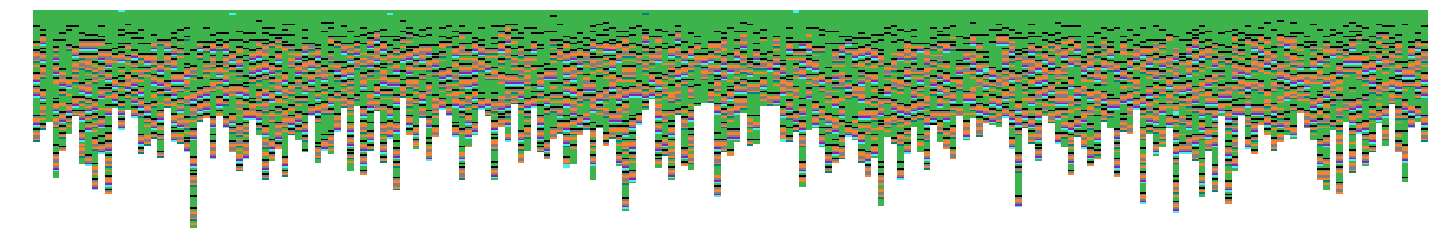

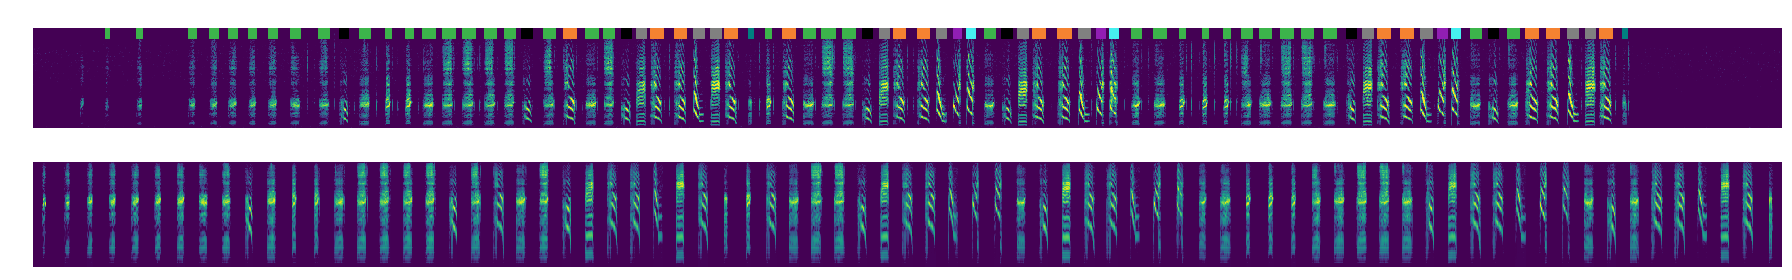

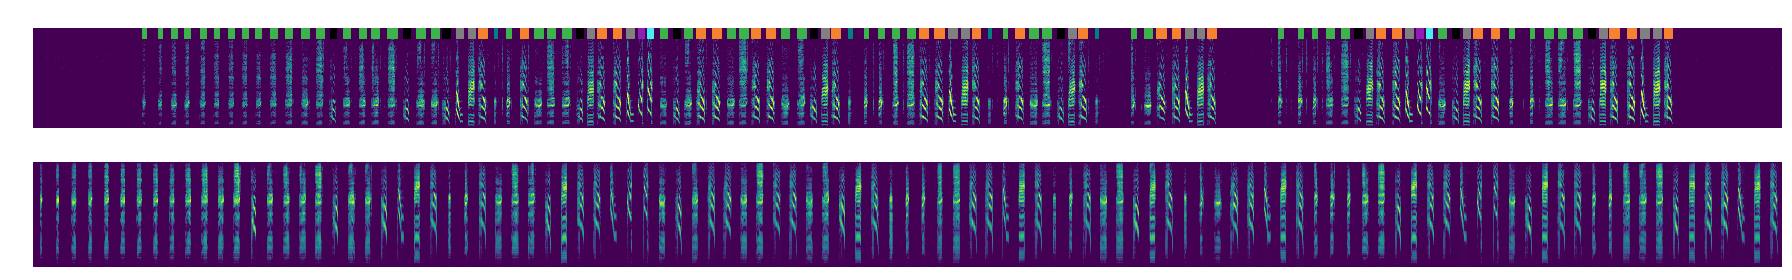

Bird6


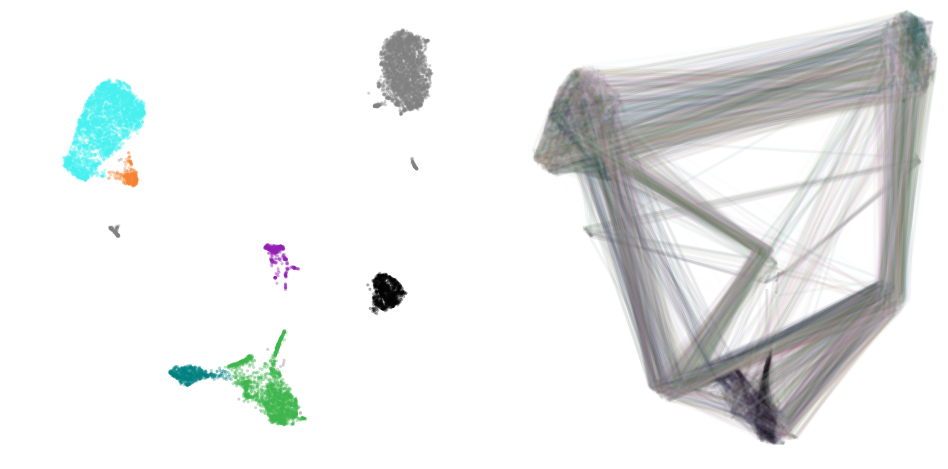

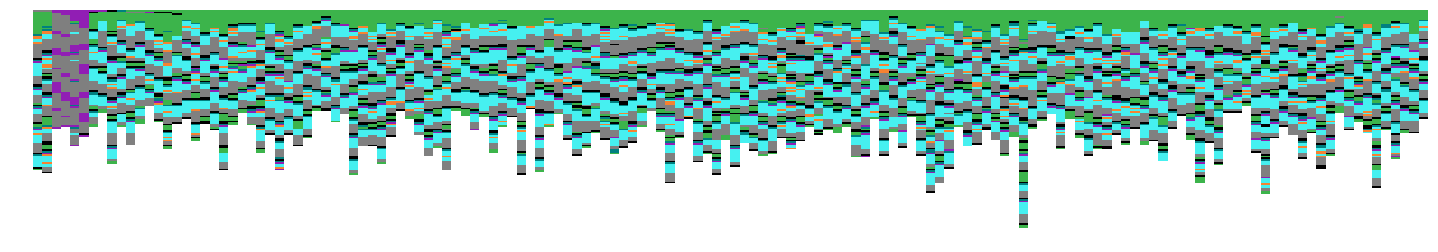

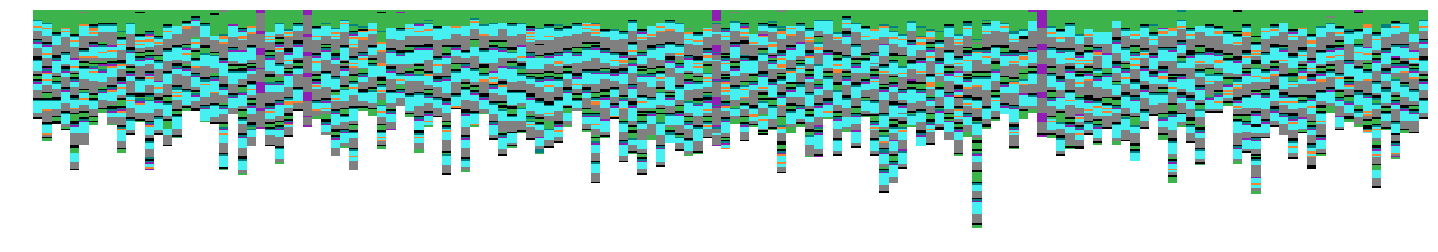

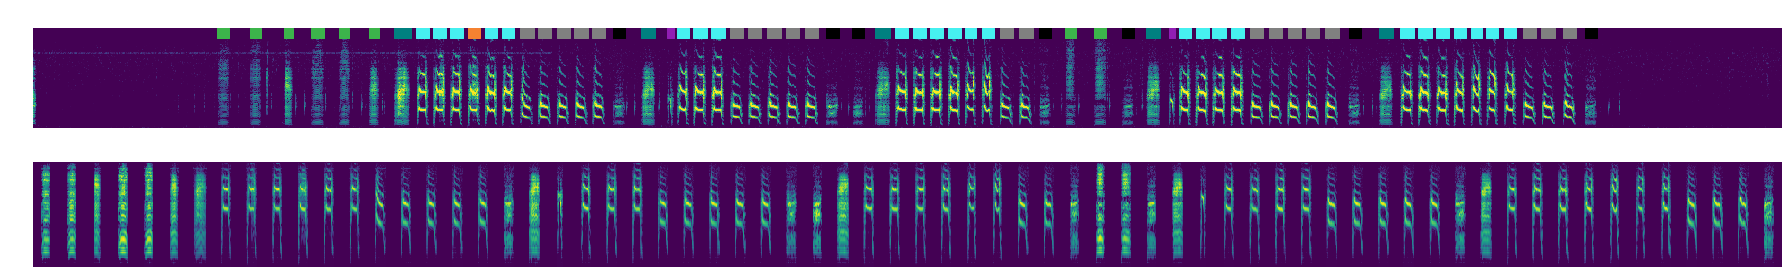

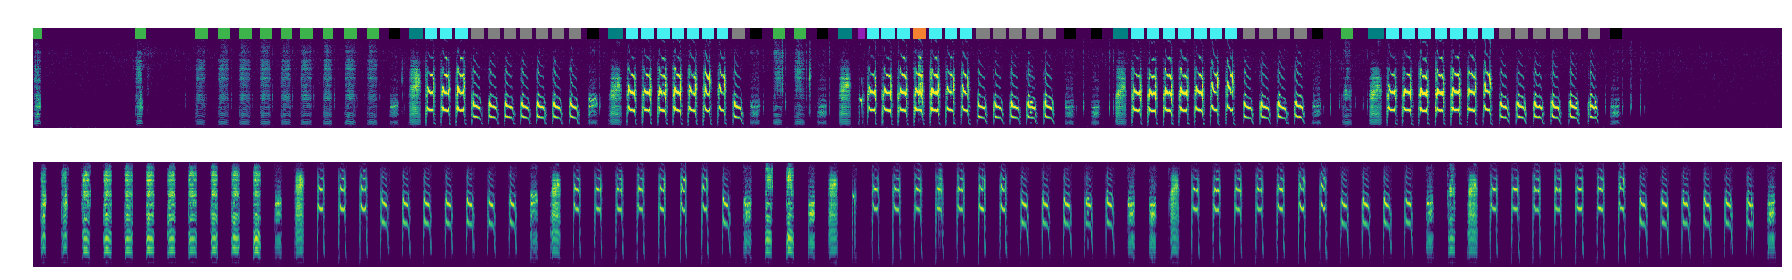

Bird5


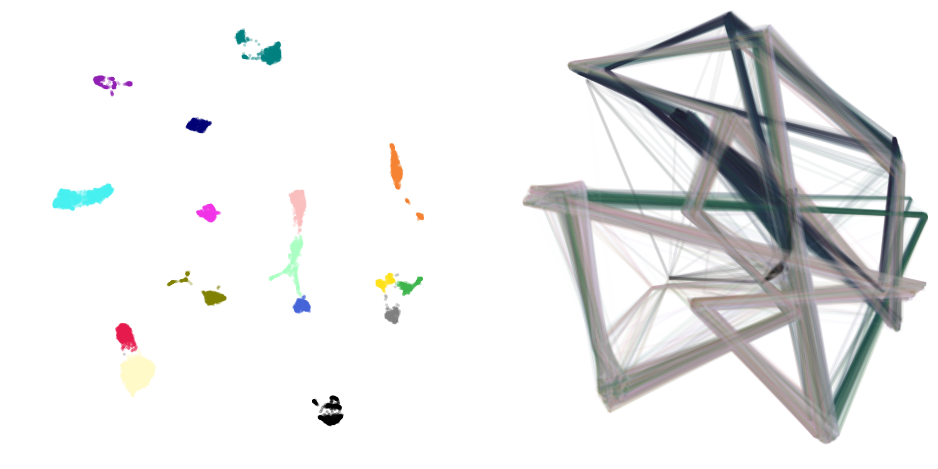

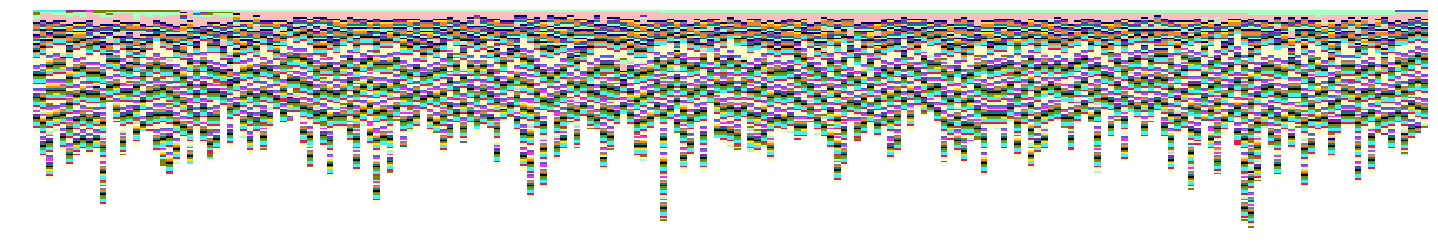

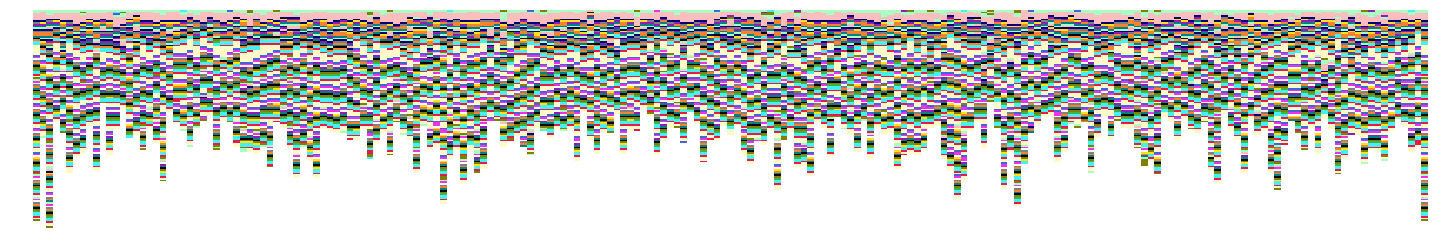

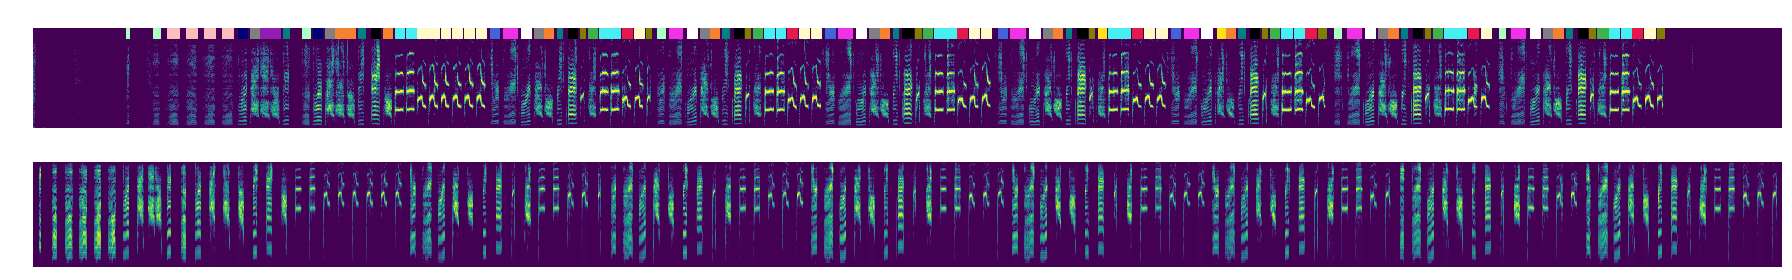

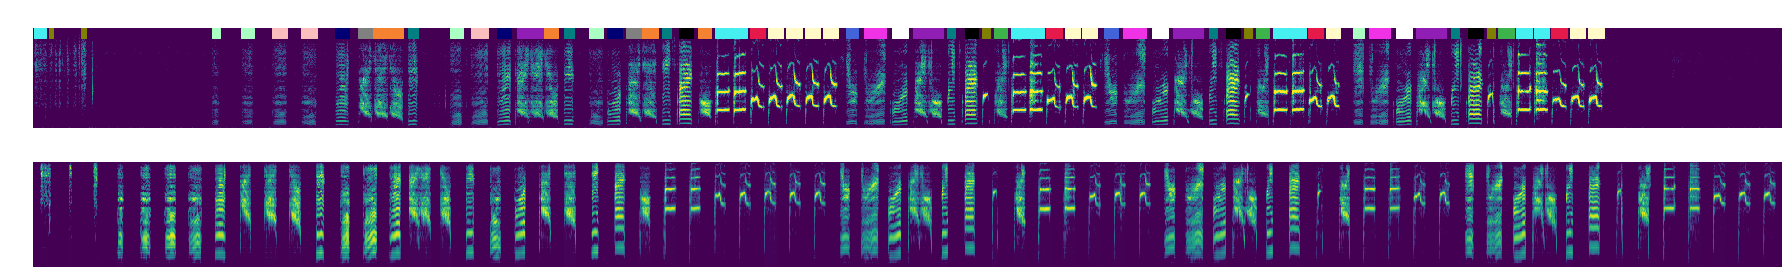

Bird4


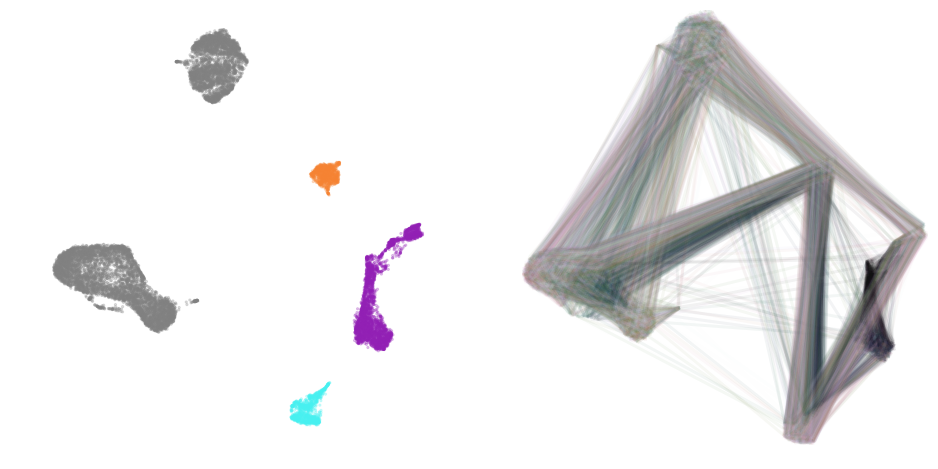

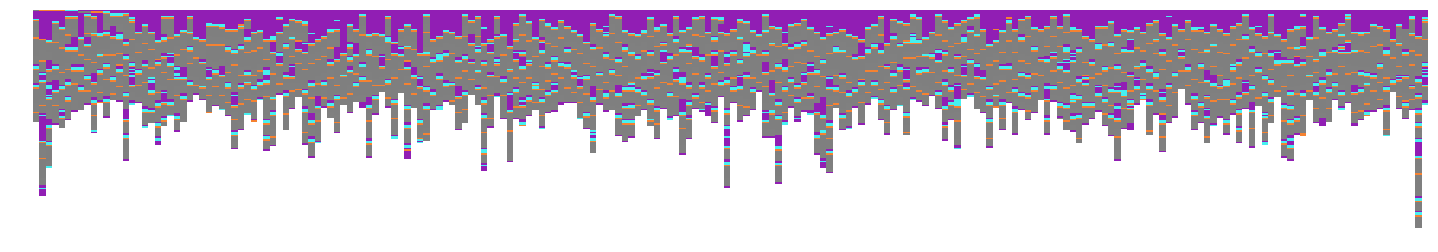

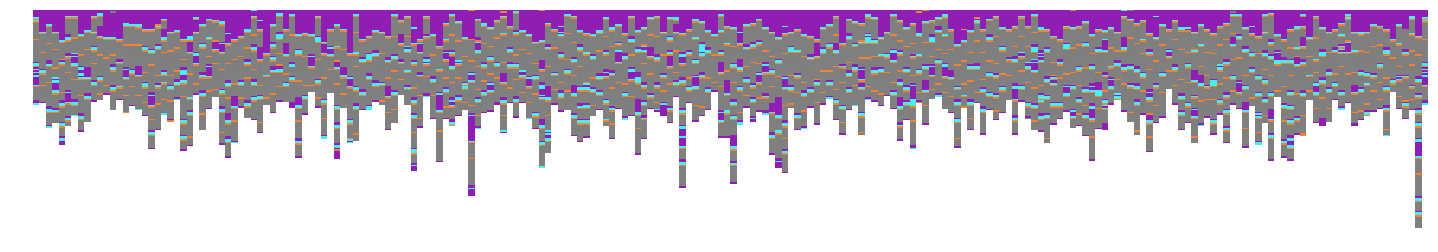

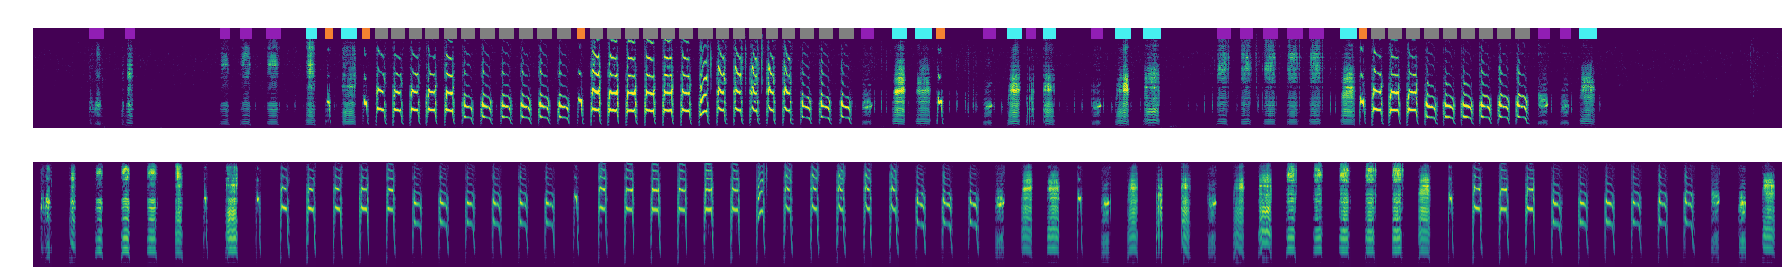

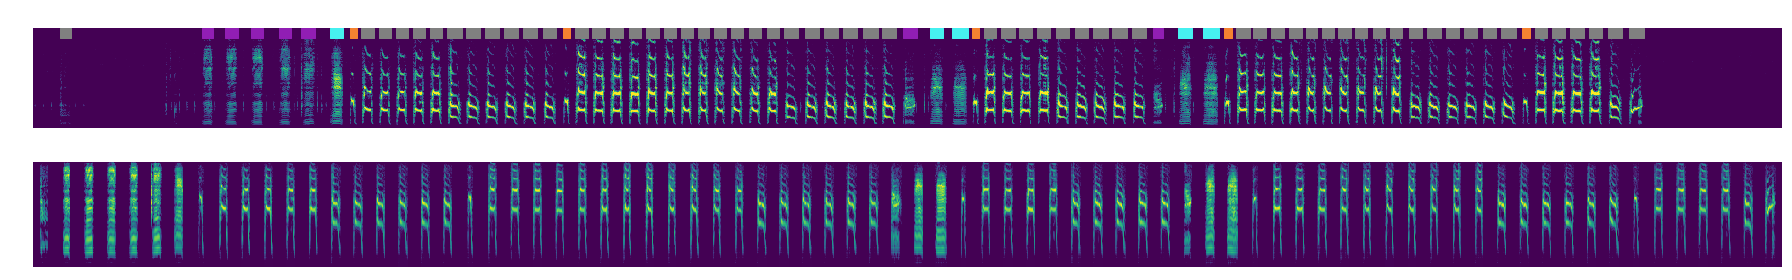

Bird2


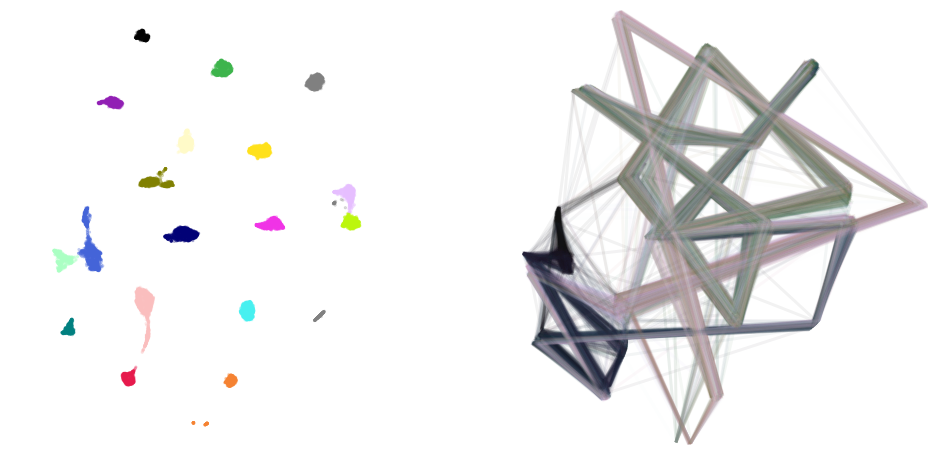

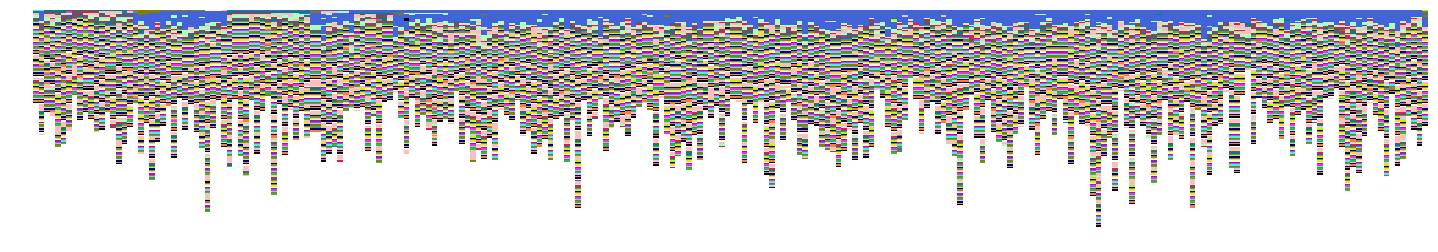

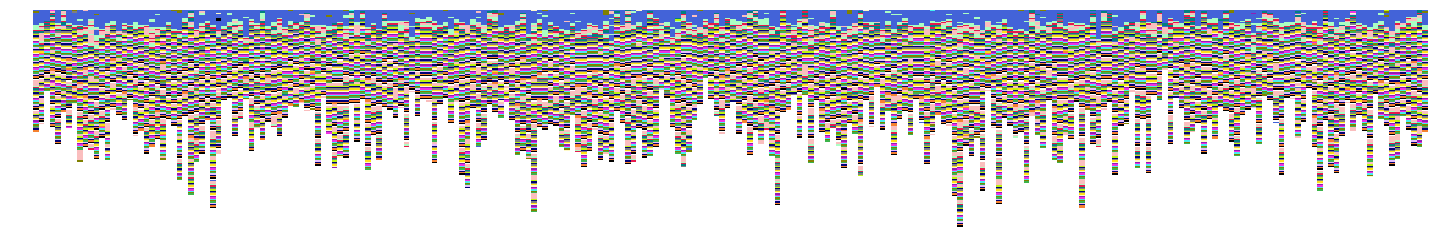

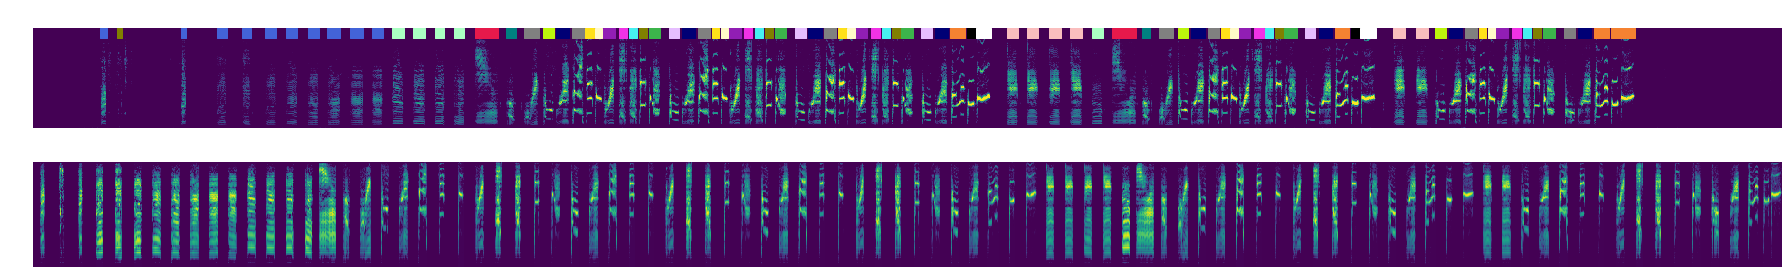

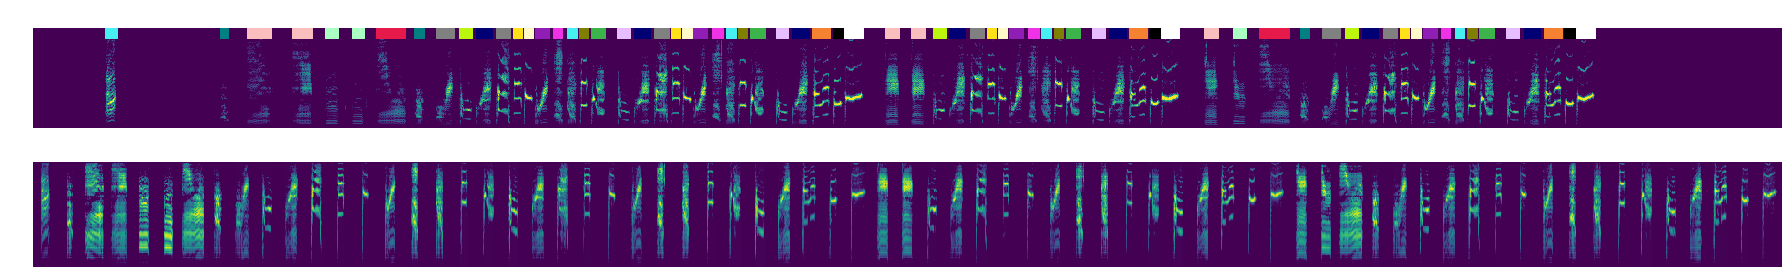

Bird0


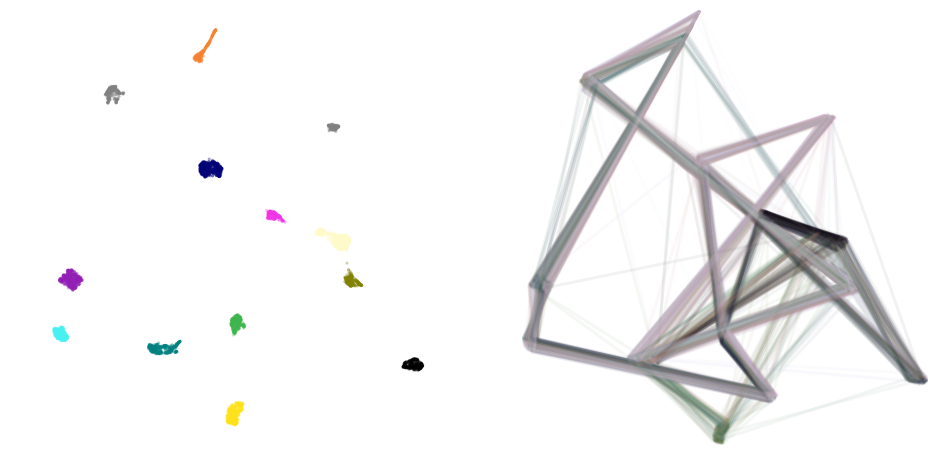

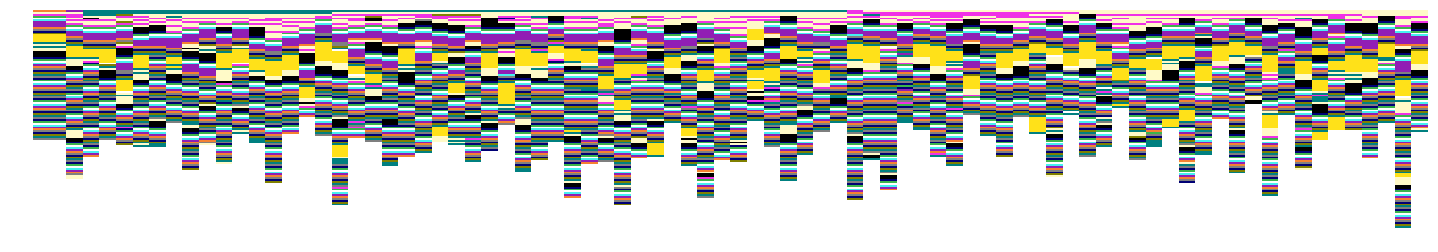

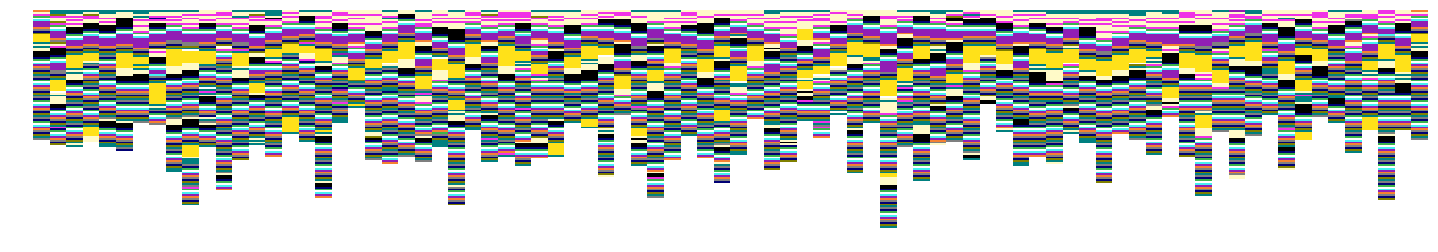

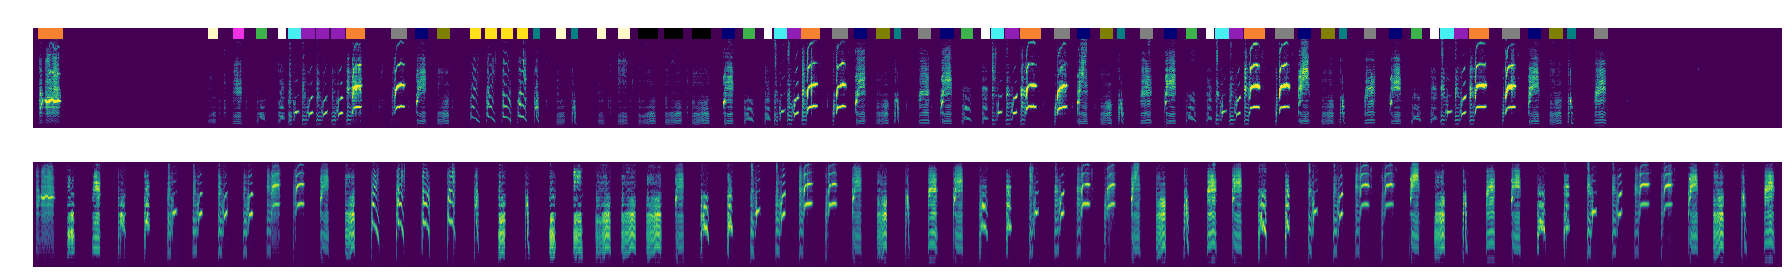

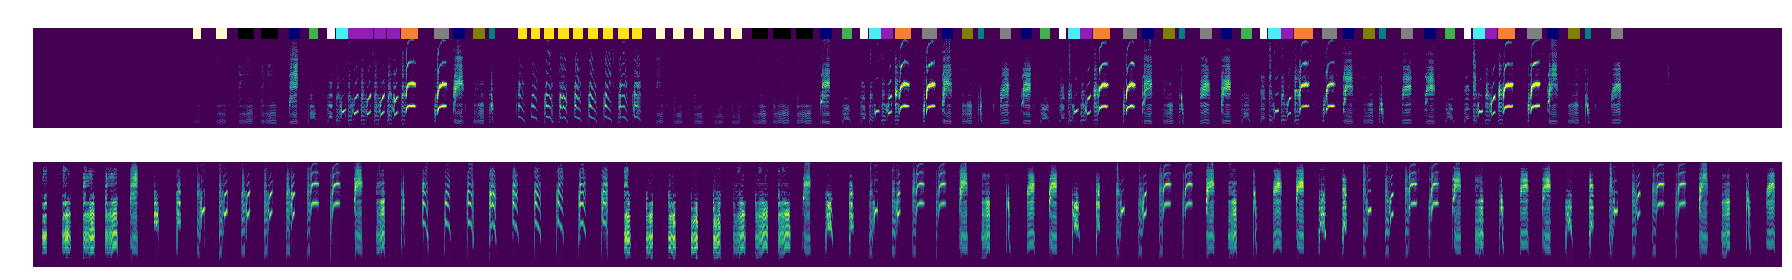

In [59]:
pal_name = 'xkcd_palette'
pal_name = np.random.permutation(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                             '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3',
                             '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
nex =2
nex_unique = 1
unique_birds = np.unique(seq_dfs.bird_name)
for bi,bird in enumerate(unique_birds[::-1]):
    print(bird)
    # plot scatter plot of song
    subset_df = seq_dfs[seq_dfs.bird_name == bird]
    labels = np.concatenate(subset_df.sequence.values)
    unique_labs= np.unique(labels)
    pal = [[.5,.5,.5]] + sns.color_palette(pal_name, len(unique_labs)-1)
    cols = {lab:col for lab, col in zip(unique_labs, pal)}
    all_col = [cols[i] for i in labels]
    z = np.concatenate([np.vstack(i) for i in subset_df.z.values])
    
    # plot transition diagram of song
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
    ax[0].scatter(z[:,0], z[:,1],s=5, c=all_col, alpha = 0.25);ax[0].axis('off')
    draw_transition_diagram(subset_df.z.values, ax=ax[1], num_ex= len(subset_df.z.values))#len(subset_df))
    plt.show()
    
    # plot bar form of song
    seqs = subset_df.sequence.values
    seqs = list(seqs) + [seqs[0]]
    seq_df, canvas, cols = colormap_seqs(seqs, sort_by = [0,1,2], palette=pal_name)
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(25,4))
    ax.imshow(np.swapaxes(canvas,0,1), interpolation='nearest', origin='upper',aspect='auto'); ax.axis('off')
    plt.show()
    
    # plot bar form of song
    seq_df, canvas, cols = colormap_seqs(seqs, palette=pal_name)
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(25,4))
    ax.imshow(np.swapaxes(canvas,0,1), interpolation='nearest', origin='upper',aspect='auto'); ax.axis('off')
    plt.show()
    
    seq_string = np.array([str(i) for i in seq_df.values])
    unique_seq = np.unique(seq_string)
    seq_freq = pd.DataFrame([[i, np.sum(seq_string == i)] for i in unique_seq], columns=['seq', 'freq']).sort_values(by='freq',ascending=False)
    
    # plot time aligned sequence segments
    for ii,(idx, row) in enumerate(seq_freq[:nex].iterrows()):
        if np.sum(row.seq == seq_string) < nex_unique: continue
        #print('number of occurances  of ', row.seq, ' :', np.sum(row.seq == seq_string))
        fig, ax = plt.subplots(nrows=2,ncols=nex_unique, figsize=(25*nex_unique,4))
        ax = np.array(ax).reshape((2,nex_unique))
        for jj in np.arange(nex_unique):
            unique_examp = seq_df.index.values[np.where(row.seq == seq_string)[0][jj]]
            #ax[0,jj].set_title(row.seq)
            #ax[1,jj].set_title([list(np.round(i,2)) for i in seq_dfs[seq_dfs.bird_name == bird].z.values[unique_examp]])
            #print(row.seq, seq_dfs[seq_dfs.bird_name == bird].sequence.values[unique_examp])
            wav_loc = seq_dfs[seq_dfs.bird_name == bird].original_wav.values[unique_examp][0][0]
            rate, data= wavfile.read(wav_loc)
            spec = sg.spectrogram(data,spec_params)
            ax[0,jj].matshow(spec, interpolation='nearest', origin='lower',aspect='auto');ax[0,jj].axis('off')
            fft_rate = np.shape(spec)[1] / (len(data)/rate )
            time_samps = np.array((seq_dfs[seq_dfs.bird_name == bird].start_time_rel_wav.values[unique_examp]/rate)*fft_rate).astype('int')
            time_lens = np.array(seq_dfs[seq_dfs.bird_name == bird].syll_length_s.values[unique_examp]*fft_rate).astype('int')
            cseq = seq_dfs[seq_dfs.bird_name == bird].sequence.values[unique_examp]
            top = np.shape(spec)[0]
            bottom = top - int(np.shape(spec)[0]*.1)
            for ts, tl, si in zip(time_samps, time_lens, cseq):
                ax[0,jj].fill_between([ts, ts+tl], [top,top],[bottom, bottom], color = cols[si])
         #break
        
        # plot individual syllables
        for jj in np.arange(nex_unique):
            unique_examp = seq_df.index.values[np.where(row.seq == seq_string)[0][jj]]
            syll_list = seq_dfs[seq_dfs.bird_name == bird].specs.values[unique_examp]
            ax[1,jj].matshow(np.hstack(syll_list), interpolation='nearest', origin='lower',aspect='auto');ax[1,jj].axis('off')
            
        plt.tight_layout()
        plt.show()        
    #break